# Unsupervised Clustering of Pet Photos

### What am i doing in this notebook?

In this notebook, I will explore how I can give the computer a group of pet images, and it can cluster the ones with the same animals together.

I will be doing that by encoding the images through a trained convolutional network, and then apply a clustering algorithm to the encoded features. We can then check the clusters and see if it worked!

### Let's import the libraries we'll need

Keras is using a TensorFlow backend in our case here.

In [9]:

import time
import os, os.path
import random
import cv2
import glob
import keras
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

import pandas as pd
import numpy as np

## Dataset loading



In [2]:
import os
import pandas as pd

script_dir = os.path.dirname(os.path.abspath("capstone.py",))
os.chdir(script_dir)
# Directory where images are stored
DIR = "./wasteimage"

def dataset_stats():
    # List of subfolder names representing different types of waste
    waste_types = ['plant', 'food', 'paper']
    
    # Dictionary where we will store the stats
    stats = []
    
    for waste_type in waste_types:
        # Construct the path to the subdirectory
        sub_directory = os.path.join(DIR, waste_type)
        
        # Get list of file names in the subdirectory
        file_names = [file for file in os.listdir(sub_directory) if os.path.isfile(os.path.join(sub_directory, file))]
        file_count = len(file_names)
        sub_directory_name = os.path.basename(sub_directory)
        # Append stats to the list
        stats.append({ "Code": sub_directory_name[:],
                            "Image count": file_count, 
                           "Folder name": os.path.basename(sub_directory),
                            "File names": file_names})
    
    # Convert stats to a DataFrame
    df = pd.DataFrame(stats)
    
    return df

# Generate the dataset statistics
dataset = dataset_stats()
# Show codes with their folder names and image counts
dataset = dataset_stats().set_index("Code")
dataset[["Folder name", "Image count"]]


,Folder name,Image count
Code,,
plant,plant,323
food,food,411
paper,paper,500


### Loading the images

Now we create a function that loads all images in a directory for a given array of codes in one array and creates the corresponding label array for them.

Loaded images are resized to 224 x 224 before storing them in our array since this is the size preferred by VGG19 which we will be using later.

In [11]:
# Function returns an array of images whoose filenames start with a given set of characters
# after resizing them to 224 x 224

def load_images(codes):
    
    # Define empty arrays where we will store our images and labels
    images = []
    labels = []
    
    for code in codes:
        # get the folder name for this code
        folder_name = dataset.loc[code]["Folder name"]
        
        for file in dataset.loc[code]["File names"]:                 
            # build file path
            file_path = os.path.join(DIR, folder_name, file)
        
            # Read the image
            image = cv2.imread(file_path)

            # Resize it to 224 x 224
            image = cv2.resize(image, (224,224))

            # Convert it from BGR to RGB so we can plot them later (because openCV reads images as BGR)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Now we add it to our array
            images.append(image)
            labels.append(code)

    return images, labels

In [12]:
codes = [ "paper","food", "plant"]
images, labels = load_images(codes)

### Randomly visualize images

Let's have a look at the breeds we loaded! The photos will not be in their original aspect ratio since we've resized them to fit what VGG needs

In [13]:
def show_random_images(images, labels, number_of_images_to_show=2):

    for code in list(set(labels)):

        indicies = [i for i, label in enumerate(labels) if label == code]
        random_indicies = [random.choice(indicies) for i in range(number_of_images_to_show)]
        figure, axis = plt.subplots(1, number_of_images_to_show)

        print("{} random images for code {}".format(number_of_images_to_show, code))

        for image in range(number_of_images_to_show):
            axis[image].imshow(images[random_indicies[image]])
        plt.show()

2 random images for code food


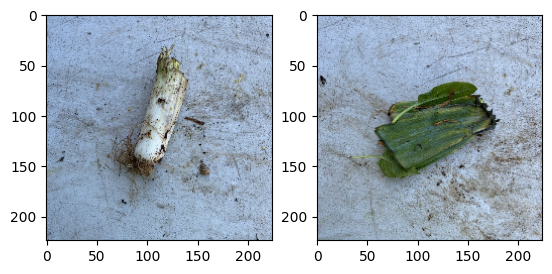

2 random images for code paper


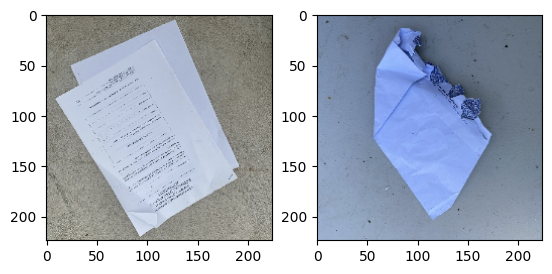

2 random images for code plant


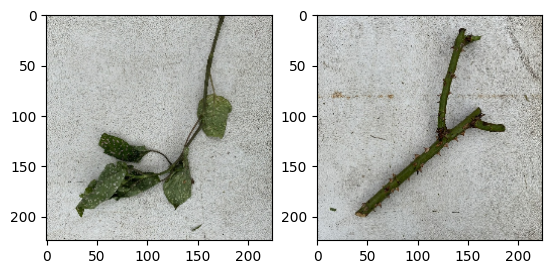

In [14]:
show_random_images(images, labels)

### Normalise (constrast enhancement)

We now convert the images and labels to NumPy arrays to make processing them easier. We then normalise the images before passing them on to VGG19

In [15]:
def normalise_images(images, labels):

    # Convert to numpy arrays
    images = np.array(images, dtype=np.float32)
    labels = np.array(labels)

    # Normalise the images
    images /= 255
    
    return images, labels

In [16]:
images, labels = normalise_images(images, labels)

### Split dataset

Now that we have all the photos and their labels in arrays. It's time to shuffle them around, and split them to three different sets... training, validation and testing.

We'll be using the `train_test_split` function from sklearn which will also shuffle the data around for us, since it's currently in order.

In [17]:
def shuffle_data(images, labels):

    # Set aside the testing data. We won't touch these until the very end.
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=728)
    
    return X_train, y_train

In [18]:
X_train, y_train = shuffle_data(images, labels)

### Load pre-trained covnet models for FEATURE EXTRACTION
#### VGG16, VG19, ResNet50

We'll now load up the keras models with the imagenet weights. We'll remove the top dense layers, since we won't need to classify things here, and we just want these encoded features from the images.

In [19]:
# Load the models with ImageNet weights for extracting image features for futher tasks(like object detection or image classi)
#USED/RUN separately,INDEPENDENTLY for the same task
vgg16_model = keras.applications.vgg16.VGG16(include_top=False, weights="imagenet", input_shape=(224,224,3)) 

vgg19_model = keras.applications.vgg19.VGG19(include_top=False, weights="imagenet", input_shape=(224,224,3)) #a variant of VGG16 with three additional convolutional layers.

resnet50_model = keras.applications.resnet50.ResNet50(include_top=False, weights="imagenet", input_shape=(224,224,3)) #3 color channels RGB




### feature extraction=> feature arrays


The covnet models will give us 3D vectors that represent the image. We need to flatten these for the clustering algorithms to start working with them.

In [20]:
def covnet_transform(covnet_model, raw_images):

    # Pass raw images => a set of feature maps (3d array) detected by the models
    pred = covnet_model.predict(raw_images)

    # Flatten the array 3D=>2D
    flat = pred.reshape(raw_images.shape[0], -1)
    #(100, 7, 7, 512) representing 100 images, each with 7x7 feature maps of depth 512
    # => (100, 25088), where each row represents an image and each column represents a feature
    return flat


In [21]:
vgg16_output = covnet_transform(vgg16_model, X_train)
print("VGG16 flattened output has {} features".format(vgg16_output.shape[1]))

vgg19_output = covnet_transform(vgg19_model, X_train)
print("VGG19 flattened output has {} features".format(vgg19_output.shape[1]))

resnet50_output = covnet_transform(resnet50_model, X_train)
print("ResNet50 flattened output has {} features".format(resnet50_output.shape[1]))

31/31 ━━━━━━━━━━━━━━━━━━━━ 212s 7s/step
VGG16 flattened output has 25088 features
31/31 ━━━━━━━━━━━━━━━━━━━━ 188s 6s/step
VGG19 flattened output has 25088 features
31/31 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step
ResNet50 flattened output has 100352 features


The above cell shows us the number of features each covnet gives to a single image. When we compare these to the original size of the image 224 x 224 x 3 = 150,528 pixels/features, we can see that this is a large reduction in what the clustering algorithms will have to work with.

CNNs are designed to gradually reduce the spatial dimensions (width and height) of the input through their layers while increasing the depth (number of feature maps). The idea is to capture the high-level features (like shapes, textures, or even whole objects) in the deeper layers of the network=> features can be reduced that much

Hopefully these reduces number of feature are represent more meaningful features in the image structure.

### PCA(dimensionality reduction)

In [22]:
# Function that creates a PCA instance, fits it to the data and returns the instance
def create_fit_PCA(data, n_components=None):
    
    p = PCA(n_components=n_components, random_state=728)
    p.fit(data)
    
    return p
    

In [23]:
# Create PCA instances for each covnet output
vgg16_pca = create_fit_PCA(vgg16_output)
vgg19_pca = create_fit_PCA(vgg19_output)
resnet50_pca = create_fit_PCA(resnet50_output)


In [24]:
# Function to plot the cumulative explained variance of PCA components
# This will help us decide how many components we should reduce our features to
def pca_cumsum_plot(pca):
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')
    plt.show()

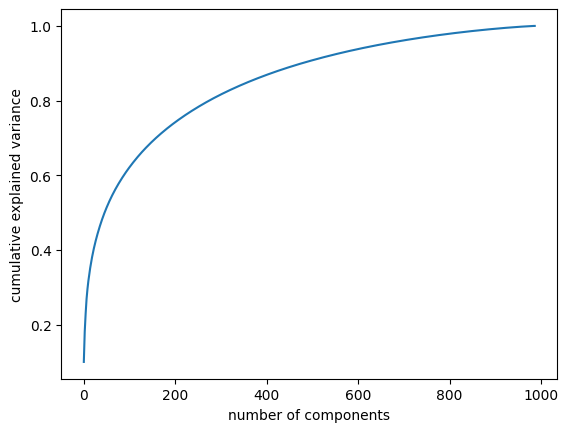

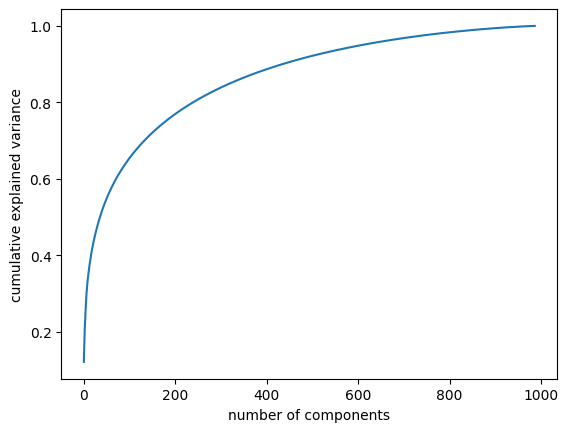

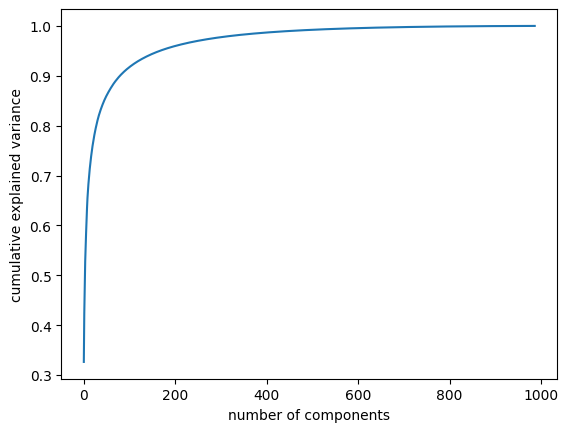

In [25]:
# Plot the cumulative explained variance for each covnet
pca_cumsum_plot(vgg16_pca)
pca_cumsum_plot(vgg19_pca)
pca_cumsum_plot(resnet50_pca)

Looking at the gaphs above, we can see that PCA can explain almost all the variance in as many dimensions as there are samples.

It is also interesting to note the difference in shape between the VGG graphs and the ResNet one. This is probably due to the fact that ResNet only had 2048 dimensions to start with, while VGGs had 25,088

In [26]:
# PCA transformations of covnet outputs
vgg16_output_pca = vgg16_pca.transform(vgg16_output)
vgg19_output_pca = vgg19_pca.transform(vgg19_output)
resnet50_output_pca = resnet50_pca.transform(resnet50_output)

### APPLY CLUSTERING ON EACH FEATURE EXTRATOR MODELS



In [27]:
def create_train_kmeans(data, number_of_clusters=len(codes)):
    
    k = KMeans(n_clusters=number_of_clusters, random_state=728)

    # Let's do some timings to see how long it takes to train.
    start = time.time()

    # Train it up
    k.fit(data)

    # Stop the timing 
    end = time.time()

    # And see how long that took
    print("Training took {} seconds".format(end-start))
    
    return k

#### Fitting KMeans models to the PCA outputs of the CNN models

In [28]:
# Let's pass the data into the algorithm and predict who lies in which cluster. 
# Since we're using the same data that we trained it on, this should give us the training results.

# Here we create and fit a KMeans model with the PCA outputs
print("KMeans (PCA): \n")

print("VGG16")
K_vgg16_pca = create_train_kmeans(vgg16_output_pca)

print("\nVGG19")
K_vgg19_pca = create_train_kmeans(vgg19_output_pca)

print("\nResNet50")
K_resnet50_pca = create_train_kmeans(resnet50_output_pca)

KMeans (PCA): 

VGG16
Training took 0.4732682704925537 seconds

VGG19
Training took 0.054731130599975586 seconds

ResNet50
Training took 0.01564788818359375 seconds


In [29]:
# Let's also create models for the covnet outputs without PCA for comparison
print("KMeans: \n")

print("VGG16:")
K_vgg16 = create_train_kmeans(vgg16_output)

print("\nVGG19:")
K_vgg19 = create_train_kmeans(vgg19_output)

print("\nResNet50:")
K_resnet50 = create_train_kmeans(resnet50_output)


KMeans: 

VGG16:
Training took 0.7670161724090576 seconds

VGG19:
Training took 0.5939154624938965 seconds

ResNet50:
Training took 2.348789930343628 seconds


In [30]:
# Now we get the cluster model predictions

# KMeans with PCA outputs
k_vgg16_pred_pca = K_vgg16_pca.predict(vgg16_output_pca)
k_vgg19_pred_pca = K_vgg19_pca.predict(vgg19_output_pca)
k_resnet50_pred_pca = K_resnet50_pca.predict(resnet50_output_pca)

# KMeans with CovNet outputs
k_vgg16_pred = K_vgg16.predict(vgg16_output)
k_vgg19_pred = K_vgg19.predict(vgg19_output)
k_resnet50_pred = K_resnet50.predict(resnet50_output)


Remember that the clustering algorith groups images that look alike together and assigns them a number arbitrarily. 

We now need to count how many of each label are in  each cluster, this way we can take a look and if sufficient eperation has happened we can quicly see which cluster is which label. So let's write a function that does that.

In [61]:
def cluster_label_count(clusters, labels):
    
    count = {}
    
    # Get unique clusters and labels
    unique_clusters = list(set(clusters))
    unique_labels = list(set(labels))
    
    # Create counter for each cluster/label combination and set it to 0
    for cluster in unique_clusters:
        count[cluster] = {}
        
        for label in unique_labels:
            count[cluster][label] = 0
    
    # Let's count
    for i in range(len(clusters)):
        count[clusters[i]][labels[i]] +=1
    
    cluster_df = pd.DataFrame(count)
    
    return cluster_df, count


In [81]:
# Cluster counting for VGG16 Means
vgg16_cluster_count = cluster_label_count(k_vgg16_pred, y_train)
vgg16_cluster_count_pca = cluster_label_count(k_vgg16_pred_pca, y_train)

# VGG19 KMeans
vgg19_cluster_count = cluster_label_count(k_vgg19_pred, y_train)
vgg19_cluster_count_pca = cluster_label_count(k_vgg19_pred_pca, y_train)

# ResNet50 KMeans
resnet_cluster_count = cluster_label_count(k_resnet50_pred, y_train)
resnet_cluster_count_pca = cluster_label_count(k_resnet50_pred_pca, y_train)



In [63]:
print("KMeans VGG16: ")
vgg16_cluster_count

KMeans VGG16: 


(         0    1    2
 food     0  152  182
 paper  260   26  107
 plant    0  251    9,
 {0: {'food': 0, 'paper': 260, 'plant': 0},
  1: {'food': 152, 'paper': 26, 'plant': 251},
  2: {'food': 182, 'paper': 107, 'plant': 9}})

In [64]:
print("KMeans VGG16 (PCA): ")
vgg16_cluster_count_pca

KMeans VGG16 (PCA): 


(         0    1    2
 food     0  152  182
 paper  260   26  107
 plant    0  251    9,
 {0: {'food': 0, 'paper': 260, 'plant': 0},
  1: {'food': 152, 'paper': 26, 'plant': 251},
  2: {'food': 182, 'paper': 107, 'plant': 9}})

In [65]:
print("KMeans VGG19: ")
vgg19_cluster_count

KMeans VGG19: 


(         0    1    2
 food     0   32  302
 paper  202  172   19
 plant    1   10  249,
 {0: {'food': 0, 'paper': 202, 'plant': 1},
  1: {'food': 32, 'paper': 172, 'plant': 10},
  2: {'food': 302, 'paper': 19, 'plant': 249}})

In [66]:
print("KMeans VGG19 (PCA): ")
vgg19_cluster_count_pca

KMeans VGG19 (PCA): 


(         0    1    2
 food     0   32  302
 paper  202  172   19
 plant    1   10  249,
 {0: {'food': 0, 'paper': 202, 'plant': 1},
  1: {'food': 32, 'paper': 172, 'plant': 10},
  2: {'food': 302, 'paper': 19, 'plant': 249}})

In [67]:
print("KMeans Resnet50: ")
resnet_cluster_count

KMeans Resnet50: 


(        0    1    2
 food    1  259   74
 paper  62  194  137
 plant  11  173   76,
 {0: {'food': 1, 'paper': 62, 'plant': 11},
  1: {'food': 259, 'paper': 194, 'plant': 173},
  2: {'food': 74, 'paper': 137, 'plant': 76}})

In [68]:
print("Kmeans Resnet50 (PCA): ")
resnet_cluster_count_pca

Kmeans Resnet50 (PCA): 


(        0    1    2
 food    1  259   74
 paper  62  194  137
 plant  11  173   76,
 {0: {'food': 1, 'paper': 62, 'plant': 11},
  1: {'food': 259, 'paper': 194, 'plant': 173},
  2: {'food': 74, 'paper': 137, 'plant': 76}})

### LABEL ASSIGNMENT AND MODEL EVALUATION

In [83]:
from sklearn.cluster import KMeans
import time
import pandas as pd

# Assuming k_vgg16_pred_pca, k_vgg19_pred_pca, k_resnet50_pred_pca, and y_train are already defined

def get_max_label_per_cluster(cluster_count): 
    cluster_code = []
    for cluster in sorted(cluster_count.keys()):
        max_label = max(cluster_count[cluster], key=cluster_count[cluster].get)
        cluster_code.append(max_label)
    return cluster_code


# Get cluster codes based on max label count
vgg16_cluster_code_pca = get_max_label_per_cluster(vgg16_cluster_count_pca)
vgg16_cluster_code = get_max_label_per_cluster(vgg16_cluster_count)
vgg19_cluster_code_pca = get_max_label_per_cluster(vgg19_cluster_count_pca)
vgg19_cluster_code = get_max_label_per_cluster(vgg19_cluster_count)
resnet_cluster_code_pca = get_max_label_per_cluster(resnet_cluster_count_pca)
resnet_cluster_code = get_max_label_per_cluster(resnet_cluster_count)


# Predict codes
vgg16_pred_codes_pca = [vgg16_cluster_code_pca[x] for x in k_vgg16_pred_pca]
vgg16_pred_codes = [vgg16_cluster_code_pca[x] for x in k_vgg16_pred]
vgg19_pred_codes_pca = [vgg19_cluster_code_pca[x] for x in k_vgg19_pred_pca]
vgg19_pred_codes = [vgg19_cluster_code_pca[x] for x in k_vgg19_pred]
resnet_pred_codes_pca = [resnet_cluster_code_pca[x] for x in k_resnet50_pred_pca]
resnet_pred_codes = [resnet_cluster_code_pca[x] for x in k_resnet50_pred]

# Function to print scores
from sklearn.metrics import accuracy_score, f1_score

def print_scores(true, pred):
    acc = accuracy_score(true, pred)
    f1 = f1_score(true, pred, average="macro")
    return "\n\tF1 Score: {0:0.8f}   |   Accuracy: {1:0.8f}".format(f1, acc)

# Print the scores
print("KMeans VGG16  ", print_scores(y_train, vgg16_pred_codes))
print("KMeans VGG16 (PCA)",print_scores(y_train, vgg16_pred_codes_pca))
print("KMeans VGG19 ", print_scores(y_train, vgg19_pred_codes))
print("KMeans VGG19 ", print_scores(y_train, vgg19_pred_codes_pca))
print("KMeans ResNet (PCA)", print_scores(y_train, resnet_pred_codes))
print("KMeans ResNet (PCA)", print_scores(y_train, resnet_pred_codes_pca))


KMeans VGG16   
	F1 Score: 0.70028873   |   Accuracy: 0.70212766
KMeans VGG16 (PCA) 
	F1 Score: 0.70028873   |   Accuracy: 0.70212766
KMeans VGG19  
	F1 Score: 0.53053279   |   Accuracy: 0.68490375
KMeans VGG19  
	F1 Score: 0.53053279   |   Accuracy: 0.68490375
KMeans ResNet (PCA) 
	F1 Score: 0.35581160   |   Accuracy: 0.46403242
KMeans ResNet (PCA) 
	F1 Score: 0.35581160   |   Accuracy: 0.46403242


#### note:

1. The scores (and cluster counts) of PCA and non-PCA transformed outputs are exactly the same. Since we fixed all random states, with the only difference being the inputs, we can see that PCA-transformed data adequately represents the original data while givig us faster training times and lower memory usage.

2. The clusters for PCA and non-PCA transformed data are exactly in the same order.